<a href="https://colab.research.google.com/github/Selinduman/Hypatia/blob/main/denememarkowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [147]:
!pip install python-binance

In [148]:
!pip install PyPortfolioOpt

In [149]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [150]:
df=pd.read_csv("APPLE.csv")
df1=pd.read_csv("AMAZON.csv")
df2=pd.read_csv("NETFLİX.csv")

In [151]:
stocks=pd.concat([df["Adj Close"],df1["Adj Close"],df2["Adj Close"]],axis=1)
stocks.columns=["Apple","Amazon","Netflix"]
stocks

,Apple,Amazon,Netflix
0,123.257416,3081.679932,520.250000
1,124.828087,3091.860107,524.030029
2,124.022865,3135.729980,524.440002
3,119.817863,3027.989990,504.790009
4,119.281052,3074.959961,512.179993
...,...,...,...
248,157.440002,2720.290039,341.760010
249,162.949997,2785.580078,358.790009
250,158.520004,2936.350098,356.769989
251,154.729996,2910.489990,340.320007


In [69]:
returns = stocks.pct_change()
returns

,Apple,Amazon,Netflix
0,NaN,NaN,NaN
1,0.012743,0.003303,0.007266
2,-0.006451,0.014189,0.000782
3,-0.033905,-0.034359,-0.037469
4,-0.004480,0.015512,0.014640
...,...,...,...
248,-0.011676,-0.010465,-0.024268
249,0.034997,0.024001,0.049830
250,-0.027186,0.054125,-0.005630
251,-0.023909,-0.008807,-0.046108


In [70]:
returns= returns.drop(0)

In [71]:
returns

,Apple,Amazon,Netflix
1,0.012743,0.003303,0.007266
2,-0.006451,0.014189,0.000782
3,-0.033905,-0.034359,-0.037469
4,-0.004480,0.015512,0.014640
5,0.028336,0.011678,0.021340
...,...,...,...
248,-0.011676,-0.010465,-0.024268
249,0.034997,0.024001,0.049830
250,-0.027186,0.054125,-0.005630
251,-0.023909,-0.008807,-0.046108


Text(0, 0.5, 'returns')

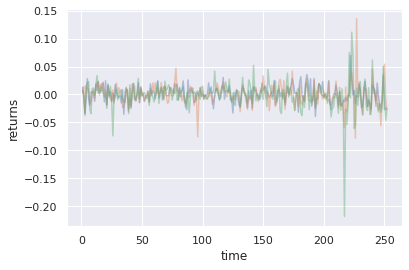

In [72]:
plt.plot(returns, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [73]:
numpy_array = df.to_numpy()

print(type(numpy_array))

<class 'numpy.ndarray'>


In [74]:
import pandas as pd

import numpy as np



data = returns



df = pd.DataFrame(data, columns = ["Apple","Amazon","Netflix"])



df

,Apple,Amazon,Netflix
1,0.012743,0.003303,0.007266
2,-0.006451,0.014189,0.000782
3,-0.033905,-0.034359,-0.037469
4,-0.004480,0.015512,0.014640
5,0.028336,0.011678,0.021340
...,...,...,...
248,-0.011676,-0.010465,-0.024268
249,0.034997,0.024001,0.049830
250,-0.027186,0.054125,-0.005630
251,-0.023909,-0.008807,-0.046108


In [134]:
returns = df[["Apple","Amazon","Netflix"]].to_numpy()

get=returns.T


In [76]:
n_assets=3

In [135]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))



[0.76799351 0.01603684 0.21596966]


In [136]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [137]:
n_portfolios = 500
means, sigma = np.column_stack([random_portfolio(get) for _ in range(n_portfolios)])

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

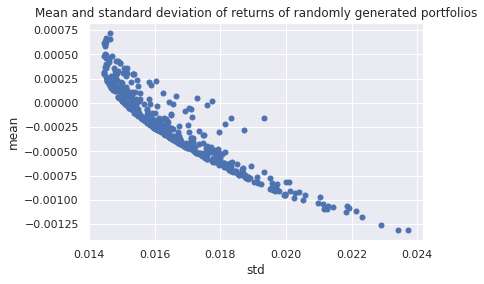

In [138]:
plt.plot(sigma, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [143]:
n_portfolios = 500
means, stds = np.column_stack([random_portfolio(get) for _ in range(n_portfolios)])

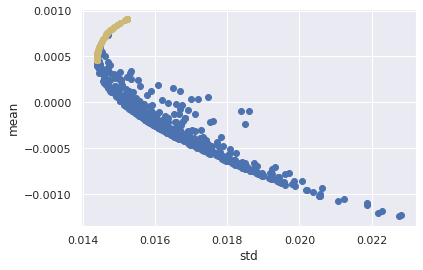

In [144]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(get)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')


plt.plot(risks, returns, 'y-o')



